# Implementation of the CNN 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import pickle
from scipy.integrate import simpson
from scipy import interpolate, integrate

2023-05-26 17:37:31.656917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Function to load/save data
def full_pickle(title, data):
 pikd = open(title + '.pickle', 'wb')
 pickle.dump(data, pikd)
 pikd.close()

def loosen(file):
 pikd = open(file, 'rb')
 data = pickle.load(pikd)
 pikd.close()
 return data


#Create metrics for trainning
from tensorflow.keras import backend as K

def precision_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    predicted_positives = K.sum( K.round(K.clip(y_pred,0,1)) )
    return true_positives / ( predicted_positives + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    real_positives = K.sum( K.round(K.clip(y_true,0,1)) )
    return true_positives / (real_positives + K.epsilon())

def f_score(y_true, y_pred):
    P = precision_m(y_true, y_pred)
    R = recall_m(y_true, y_pred)
    return (2*P*R) / (P+R+K.epsilon())

#Evaluation for binary classification
def evaluate(y_pred, label): 

    index_n = np.where(label == 0)[0]
    index_p = np.where(label == 1)[0]

    true_positif = (y_seuil[index_p] == 1).sum()
    false_positif = (y_seuil[index_n] == 1).sum()

    true_negatif = (y_seuil[index_n] == 0).sum()
    false_negatif = (y_seuil[index_p] == 0).sum()

    m = np.array([
        [true_negatif, false_positif],
        [false_negatif, true_positif]
    ])
    
    precision = true_positif/(true_positif + false_positif)
    recall = true_positif/(true_positif + false_negatif)
    f_score = (2*precision*recall)/(precision+recall)
    
    return precision, recall,f_score, m


In [22]:
#Load dataset 1 for the neural network
"""
X_LS = loosen('./data/set1/LS.pickle')
X_max_values = loosen('./data/set1/Maxs.pickle')
Y = loosen('./data/set1/Labels.pickle')
freq = loosen('./data/set1/Freq.pickle')
"""

X_LS = np.load('./data/set1/X_LS.npy',allow_pickle = True)
X_max_values = np.load('./data/set1/X_max_values.npy',allow_pickle = True)
Y = np.load('./data/set1/Y.npy',allow_pickle = True)
freq = np.load('./data/set1/Freq.npy',allow_pickle = True)

In [10]:
N_data = len(X_LS)
print("X_lS : ", len(X_LS), type(X_LS))
print("X_max_values : ", len(X_max_values), type(X_max_values))

print("\n1 periodogramme : ",len(X_LS[0]), type(X_LS[0]) ) #periodogramme
print("1 max values : ", len(X_max_values[0]), type(X_max_values[0]) ) #max values 

print("Y : ", len(Y), type(Y))

X_lS :  13700 <class 'numpy.ndarray'>
X_max_values :  13700 <class 'numpy.ndarray'>

1 periodogramme :  990 <class 'numpy.ndarray'>
1 max values :  2 <class 'numpy.ndarray'>
Y :  13700 <class 'numpy.ndarray'>


In [11]:
#Data pre-processing 

#shuffle
c = list(zip(X_LS, X_max_values,Y))
random.shuffle(c)
X_LS, X_max_values,Y = zip(*c)

#Periodogramme
X_shape =  [N_data,len(X_LS[0]), 1]
X1_tensor = tf.convert_to_tensor(X_LS, dtype = 'float32')
X1 = tf.reshape(X1_tensor, X_shape )

#Max values
X2_tensor = tf.convert_to_tensor(X_max_values, dtype = 'float32')
X2 = tf.reshape(X2_tensor, (N_data, 2,1))

#Label
Y_tensor = tf.convert_to_tensor(Y,dtype='float32')
Y = tf.reshape(Y_tensor, (N_data,1 ))

#Split train/validation
pourcentage = 0.8
split = round(pourcentage * N_data)
X_train1, X_val1 = X1[0:split, :, :], X1[split:, :, :]
X_train2,X_val2 = X2[0:split, :, :], X2[split:, :, :]
Y_train, Y_val = Y[0:split], Y[split:,:]

print("Periodogramme train size : ", X_train1.shape)
print("Periodogramme validation size : ", X_val1.shape,"\n")
print("Max_values train size : ", X_train2.shape)
print("Max_values validation size : ", X_val2.shape,"\n")
print("Label train size : ", Y_train.shape)
print("Label validation size : ", Y_val.shape)

Periodogramme train size :  (10960, 990, 1)
Periodogramme validation size :  (2740, 990, 1) 

Max_values train size :  (10960, 2, 1)
Max_values validation size :  (2740, 2, 1) 

Label train size :  (10960, 1)
Label validation size :  (2740, 1)


In [12]:
#Model with functional API Keras

#periodogramme as input to a CNN
inputs1 = tf.keras.Input(shape=(990,1))
x1 = layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, padding = 'same',
                   activation='relu', use_bias = True,input_shape= (990,))(inputs1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,6,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,8,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
outputs1 = layers.Flatten()(x1)

#max_values as input to a dense layers 
inputs2 = tf.keras.Input(shape=(2,1))
x2 = layers.Dense(2, activation = 'relu')(inputs2)
outputs2 =  layers.Flatten()(x2)

#output of the two network concatenate for input as a dense final network
x = layers.concatenate([outputs1, outputs2])

x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)


In [13]:
model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="ExoplANNET")

In [14]:
model.summary()

Model: "ExoplANNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 990, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 990, 32)      96          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 495, 32)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 495, 32)      6176        ['max_pooling1d[0][0]']          
                                                                                         

In [15]:
#Train the network
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f_score', patience = 2, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

model.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
              metrics =[tf.keras.metrics.BinaryAccuracy(),precision_m, recall_m, f_score])

start = time.time()
history = model.fit(x = [X_train1, X_train2], y = Y_train, batch_size = 128, epochs = 50, verbose = 1,
                    callbacks=[early_stopping], validation_data = ([X_val1,X_val2], Y_val))
                                                                    
time_train = time.time() - start

Epoch 1/50
86/86 [==============================] - 14s 138ms/step - loss: 0.4013 - binary_accuracy: 0.8224 - precision_m: 0.8923 - recall_m: 0.7575 - f_score: 0.8030 - val_loss: 0.2875 - val_binary_accuracy: 0.8763 - val_precision_m: 0.8979 - val_recall_m: 0.8494 - val_f_score: 0.8715
Epoch 2/50
86/86 [==============================] - 11s 124ms/step - loss: 0.2845 - binary_accuracy: 0.8809 - precision_m: 0.9166 - recall_m: 0.8389 - f_score: 0.8744 - val_loss: 0.2671 - val_binary_accuracy: 0.8792 - val_precision_m: 0.9380 - val_recall_m: 0.8124 - val_f_score: 0.8696
Epoch 3/50
86/86 [==============================] - 12s 141ms/step - loss: 0.2688 - binary_accuracy: 0.8876 - precision_m: 0.9063 - recall_m: 0.8679 - f_score: 0.8847 - val_loss: 0.2474 - val_binary_accuracy: 0.8876 - val_precision_m: 0.9042 - val_recall_m: 0.8686 - val_f_score: 0.8849
Epoch 4/50
86/86 [==============================] - 12s 136ms/step - loss: 0.2514 - binary_accuracy: 0.8927 - precision_m: 0.8987 - recall_

Temps d'entrainement :  159.2548360824585 s


Text(0.5, 0, 'Epochs')

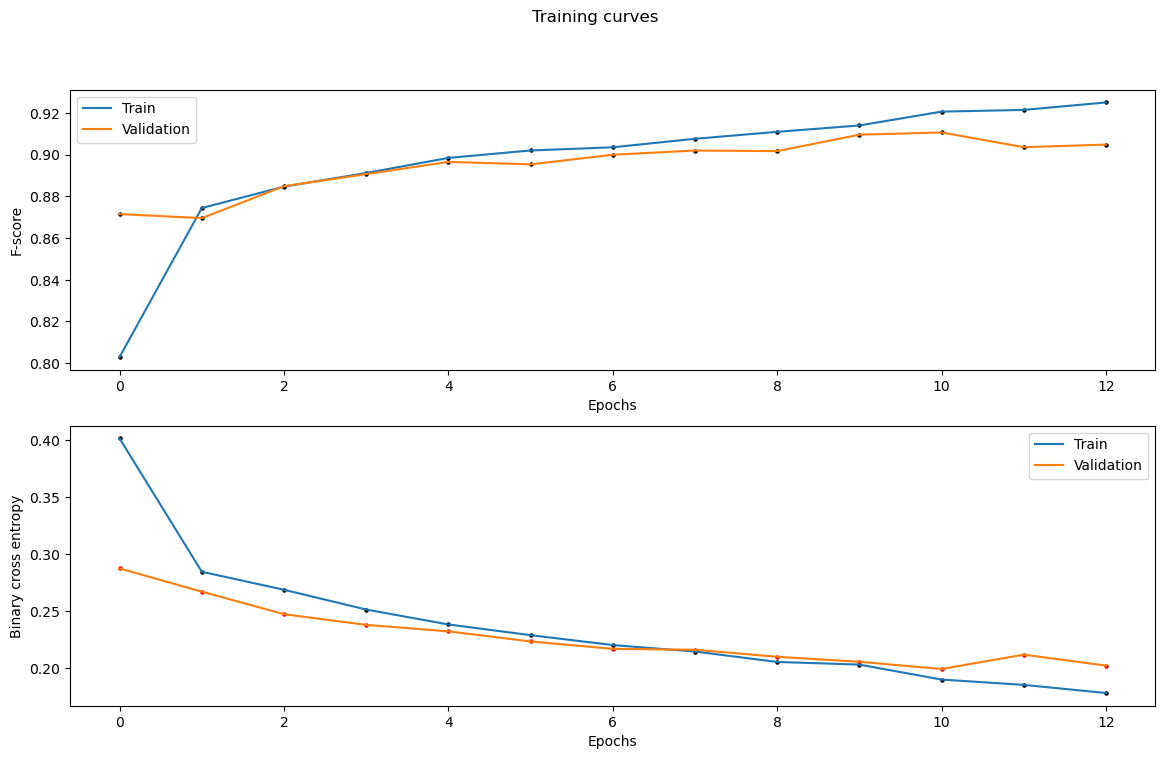

In [16]:
print("Temps d'entrainement : ", time_train, "s")

x = np.arange(len(history.history['loss']))

plt.figure(figsize=(14,8))
plt.suptitle("Training curves")
plt.subplot(211)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(history.history['f_score'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_f_score'], s=5, c='k')
plt.plot(history.history['val_f_score'], label='Validation'), plt.legend()
plt.ylabel("F-score")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['loss'], s=5, c='k')
plt.plot(history.history['loss'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_loss'], s=5, c='r')
plt.plot(history.history['val_loss'], label='Validation'), plt.legend()
plt.ylabel("Binary cross entropy")
plt.xlabel("Epochs")

In [17]:
#data set 2 test for testing
"""
X_LS_test = loosen("./data/set2/LS_test.pickle")
X_max_values_test = loosen("./data/set2/Maxs_test.pickle")
Y_test = loosen("./data/set2/Labels_test.pickle")
"""

X_LS_test = np.load('./data/set2/X_LS.npy', allow_pickle=True)
X_max_values_test = np.load('./data/set2/X_max_values.npy', allow_pickle=True)
Y_test = np.load('./data/set2/Y.npy', allow_pickle=True)

#shuffle
c = list(zip(X_LS_test, X_max_values_test,Y_test))
random.shuffle(c)
X_LS_test, X_max_values_test,Y_test = zip(*c)

#Periodogramme
X1_test_tensor = tf.convert_to_tensor(X_LS_test, dtype= 'float32')
X1_test_shape =  [len(X_LS_test),len(X_LS_test[0]), 1]
X1_test = tf.reshape(X1_test_tensor, X1_test_shape )
#Max values
X2_test_tensor = tf.convert_to_tensor(X_max_values_test, dtype= 'float32')
X2_test = tf.reshape(X2_test_tensor, (len(X_max_values_test), len(X_max_values_test[0]),1))
#Label
Y_test_tensor = tf.convert_to_tensor(Y_test)
label_test = tf.reshape(Y_test_tensor, (len(Y_test),1 ))

print("X1_test shape : ", X1_test.shape)
print("X2_test shape : ", X2_test.shape)
print("label_test shape : ", label_test.shape)

X1_test shape :  (10000, 990, 1)
X2_test shape :  (10000, 2, 1)
label_test shape :  (10000, 1)


In [18]:
#Evaluation with samples from dataset2
y_pred_d2 = model.predict( x =[X1_test, X2_test])

313/313 [==============================] - 14s 43ms/step


Best F-score achieve by CNN =  0.875  with threshold =  0.735
Confusion matrix :  [[6893  260]
 [ 431 2416]]


Text(0, 0.5, 'Precision')

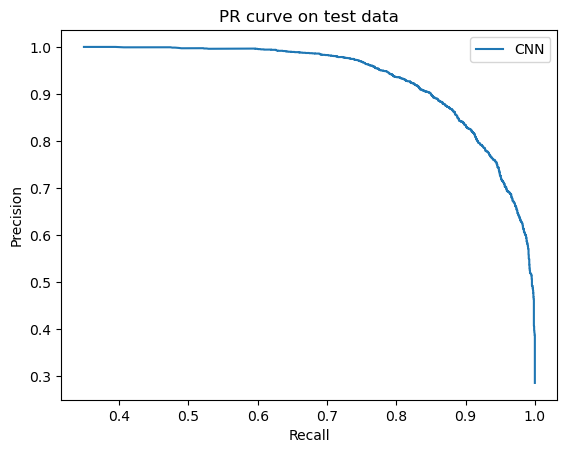

In [19]:
N = 10000
threshold = np.linspace(0.0001,0.9999,N)
P = np.zeros(N)
R = np.zeros(N)
best_score = 0

for i in range(N):
    y_seuil = np.where(y_pred_d2 > threshold[i],1,0)
    P[i] ,R[i],f,m = evaluate(y_seuil,label_test) 
    if (f > best_score) : best_score, best_threshold, best_m = f, threshold[i], m
        
    
print("Best F-score achieve by CNN = ", round(best_score,3), " with threshold = ",round(best_threshold,3) )
print("Confusion matrix : ", best_m)

plt.title("PR curve on test data")
plt.plot(R,P, label='CNN'),  plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

In [23]:
#Test with data from Nieto papers

labels_test= []
LS_test = []
max_value_test =[]

for filename in np.sort(os.listdir("../Git_article/ExoplANNET/data")):
    
    if filename.endswith(".npy") :
        
        if filename.startswith("pe"): 
             LS_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))
        if filename.startswith("l"): 
             labels_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))
        if filename.startswith("po"): 
             max_value_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))

                
#Concatenate arrays
labels_p = np.concatenate((labels_test[0][:],labels_test[1][:],labels_test[2][:],labels_test[3][:],labels_test[4][:]))
LSs_p = np.concatenate((LS_test[0][:], LS_test[1][:],LS_test[2][:],LS_test[3][:],LS_test[4][:]))
max_values_p = np.concatenate((max_value_test[0][:],max_value_test[1][:],max_value_test[2][:],max_value_test[3][:],max_value_test[4][:]) ) 

#Shuffle
c = list(zip(LSs_p, max_values_p,labels_p))
random.shuffle(c)
LSs_p, max_values_p,labels_p = zip(*c)

for i in range(len(max_values_p)):
    max_values_p[i][0] = freq[round(max_values_p[i][0])]

#Convert to tensor
X1_p = tf.convert_to_tensor(LSs_p, dtype= 'float32')
X_p_shape =  [len(LSs_p),len(X_LS[0]), 1]
X1_p = tf.reshape(X1_p, X_p_shape )

#Max values
X2_p = tf.convert_to_tensor(max_values_p, dtype= 'float32')
X2_p = tf.reshape(X2_p, (len(LSs_p), 2,1))

#Label
Y_p = tf.convert_to_tensor(labels_p)
Y_p = tf.reshape(Y_p, (len(LSs_p),1 ))


print("X1_test shape : ", X1_p.shape)
print("X2_test shape : ", X2_p.shape)
print("Y_test shape : ", Y_p.shape)

X1_test shape :  (20000, 990, 1)
X2_test shape :  (20000, 2, 1)
Y_test shape :  (20000, 1)


In [24]:
#Evaluation
y_pred = model.predict( x =[X1_p, X2_p])

625/625 [==============================] - 27s 43ms/step


Best F-score achieve by CNN =  0.787  with threshold =  0.935
Confusion matrix :  [[14877   710]
 [ 1087  3326]]


Text(0, 0.5, 'Precision')

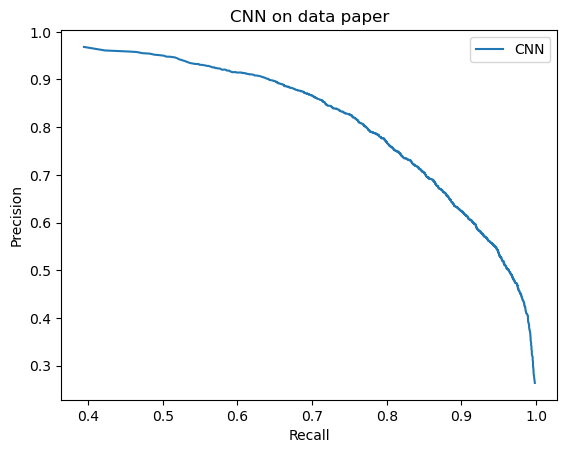

In [25]:
N = 10000
threshold = np.linspace(0.0001,0.9999,N)
P = np.zeros(N)
R = np.zeros(N)
best_score = 0

for i in range(N):
    y_seuil = np.where(y_pred > threshold[i],1,0)
    P[i] ,R[i],f,m = evaluate(y_seuil,Y_p) 
    if (f > best_score) : best_score, best_threshold, best_m = f, threshold[i], m

        
print("Best F-score achieve by CNN = ", round(best_score,3), " with threshold = ",round(best_threshold,3) )
print("Confusion matrix : ", best_m)

plt.title("CNN on data paper")
plt.plot(R,P, label='CNN'),  plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

# Paper model

In [26]:
model_paper = tf.keras.models.load_model("./../Git_article/ExoplANNET/exoplANNET_trained.h5")

In [27]:
y_pred = model_paper.predict( x =[X1_p, X2_p])

625/625 [==============================] - 30s 47ms/step


Best F-score achieve by CNN =  0.798  with threshold =  0.529
Confusion matrix :  [[14969   618]
 [ 1071  3342]]


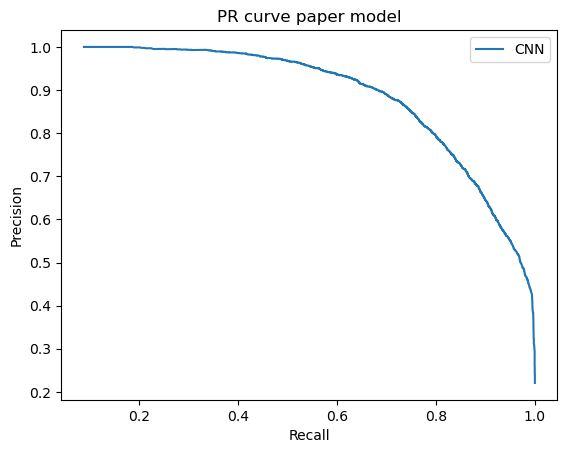

In [28]:
N = 10000
threshold = np.linspace(0.0001,0.9999,N)
P = np.zeros(N)
R = np.zeros(N)
best_score = 0
for i in range(N):
    y_seuil = np.where(y_pred > threshold[i],1,0)
    P[i] ,R[i],f,m = evaluate(y_seuil,Y_p) 
    if (f > best_score) : best_score, best_threshold, best_m = f, threshold[i], m

plt.title("PR curve paper model")
plt.plot(R,P, label='CNN'),  plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

print("Best F-score achieve by CNN = ", round(best_score,3), " with threshold = ",round(best_threshold,3) )
print("Confusion matrix : ", best_m)

# Comparaison with others methods
### 1) FAP

In [29]:
pdf_mean = loosen("./data/set2/pdf_mean.pickle")

Text(0.5, 0, 'Max amplitude')

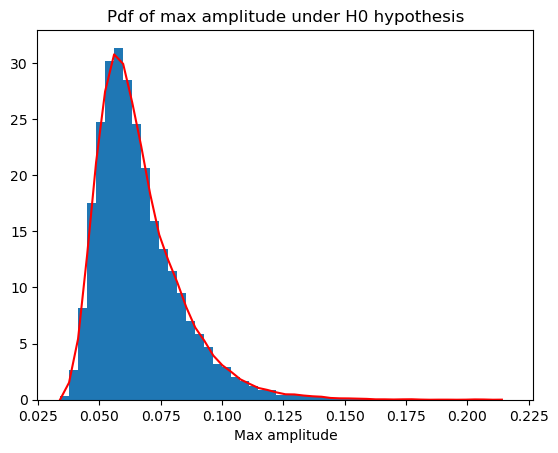

In [30]:
mean_bin = np.zeros(pdf_mean[1].shape[0]-1)
for i in range(pdf_mean[1].shape[0]-1) : mean_bin[i] = (pdf_mean[1][i+1] + pdf_mean[1][i])/2
f_pdf = interpolate.interp1d(mean_bin, pdf_mean[0],bounds_error = False, fill_value = (0,0))

plt.title("Pdf of max amplitude under H0 hypothesis")
plt.bar(pdf_mean[1][:-1], pdf_mean[0], width=np.diff(pdf_mean[1]), align='edge')
plt.plot(pdf_mean[1][:-1], f_pdf(pdf_mean[1][:-1]), c ='r')
plt.xlabel("Max amplitude")

In [31]:
# Function to compute the p-value of a distribution
def compute_p_value( pdf, xi):
    cdf = np.cumsum(pdf[0]*np.diff(pdf[1]))
    mean_bin = np.zeros(pdf[1].shape[0]-1)
    for i in range(pdf[1].shape[0]-1) : mean_bin[i] = (pdf[1][i+1] + pdf[1][i])/2
    f_cdf = interpolate.interp1d(mean_bin, cdf,bounds_error = False, fill_value = (0,1))
    p_value = 1 - f_cdf(xi)
    return np.log10(p_value)

In [32]:
# Predict label with FAP method
def predict_FAP(Maxs):
    N_test = Maxs.shape[0]
    p_vals = np.zeros(N_test)
    for i in range(N_test):
        p_vals[i] = compute_p_value(pdf_mean,Maxs[i][1])[0]
    return p_vals

In [33]:
y_pred_FAP = predict_FAP(X2_test)

/tmp/ipykernel_14659/1991116893.py:8: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p_value)


/tmp/ipykernel_14659/2221174157.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc1 = integrate.quad(f1, 0, 1)
/tmp/ipykernel_14659/2221174157.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose i


Best F-score achieve by CNN =  0.875  with threshold =  0.698
Confusion matrix :  [[6826  327]
 [ 380 2467]]
AUC =  0.955

Best F-score achieve by FAP =  0.837  with threshold =  -1.322
Confusion matrix :  [[6950  203]
 [ 650 2197]]
AUC =  0.905


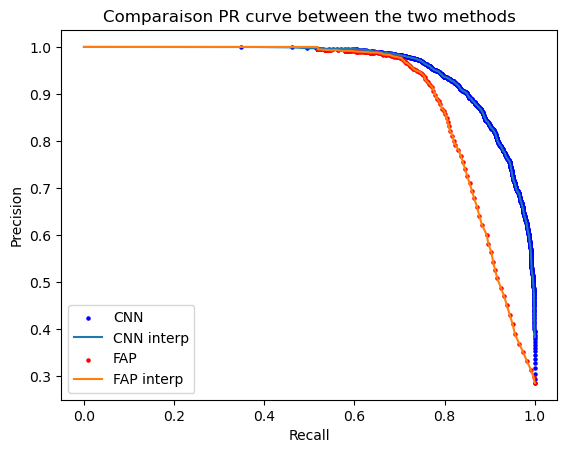

In [34]:
N = 1000
threshold1 = np.linspace(0.0001,0.9999,N)
threshold2 = np.linspace(-30,-0.001,N)
P1, R1 = np.zeros(N), np.zeros(N)
P2, R2 = np.zeros(N), np.zeros(N)
best_score_fap = 0
best_score_cnn = 0

for i in range(N):
    y_seuil = np.where(y_pred_d2 > threshold1[i],1,0)
    P1[i] ,R1[i],f,m = evaluate(y_seuil,label_test) 
    if (f > best_score_cnn) : best_score_cnn, best_threshold_cnn, best_m_cnn = f, threshold1[i], m
        
    y_seuil = np.where(y_pred_FAP < threshold2[i],1,0)
    P2[i] ,R2[i],f,m = evaluate(y_seuil,label_test)
    if (f > best_score_fap) : best_score_fap, best_threshold_fap, best_m_fap = f, threshold2[i], m 
        
x_interp = np.linspace(0,1,N)
f1 = interpolate.interp1d(R1, P1,bounds_error = False, fill_value = (1,0))
f2 = interpolate.interp1d(R2, P2,bounds_error = False, fill_value = (1,0))

auc1 = integrate.quad(f1, 0, 1)
auc2 = integrate.quad(f2, 0, 1)

plt.figure()
plt.title("Comparaison PR curve between the two methods")
plt.scatter(R1,P1, label ='CNN',s = 5, c ='b'), plt.legend()
plt.plot(x_interp,f1(x_interp),label='CNN interp'),plt.legend()
plt.scatter(R2,P2, label='FAP',s = 5, c ='r'),  plt.legend()
plt.plot(x_interp,f2(x_interp),label='FAP interp'),plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

print("\nBest F-score achieve by CNN = ", round(best_score_cnn,3), " with threshold = ",round(best_threshold_cnn,3) )
print("Confusion matrix : ", best_m_cnn)
print("AUC = ", round(auc1[0],3))
print("\nBest F-score achieve by FAP = ", round(best_score_fap,3), " with threshold = ",round(best_threshold_fap,3) )
print("Confusion matrix : ", best_m_fap)
print("AUC = ", round(auc2[0],3))